# installation

## konlpy를 위한 jdk 설치

https://www.oracle.com/kr/java/technologies/javase/javase8u211-later-archive-downloads.html

해당 링크에서 oracle 가입 및 로그인 후 Windows x64 installer 다운로드 후 설치한다.

윈도우 > 시스템 환경 변수 편집 > 환경변수 > 시스템 변수 > 새로 만들기

변수 : JAVA_HOME         
값(jdk 설치 경로) : C:\Program Files\Java\jdk-1.8

윈도우 > 시스템 환경 변수 편집 > 환경변수 > 시스템 변수 > Path > 편집 > 새로 만들기             
                          
%JAVA_HOME%\bin;

윈도우 cmd에서 $java -version      
으로 설치 확인

## 라이브러리 설치

In [1]:
!pip install wordcloud
!pip install kss
!pip install konlpy
!pip install scikit-learn
!pip install selenium

# import

In [2]:
import re
import os
import base64
import math
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import certifi
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
import warnings
warnings.filterwarnings(action='ignore')
import kss
from konlpy.tag import Okt, Kkma
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize 

# 필요한 파일 준비

## stopwords-ko.txt 파일과 같은 경로에 다운로드

## 파일과 같은 경로에 wordcloud_mask.png 이름의 wordcloud 생성을 위한 mask 이미지 저장

# Text에서 stopwords 제거 및 문장 자르기

In [3]:
class TextAnalyzer:
    def __init__(self):
        self.okt = Okt()
        self.kkma = Kkma()
        self.stopwords = []
        stopwords_path = './stopwords-ko.txt'
        with open(stopwords_path, 'r', encoding='UTF8') as file:
            for line in file:
                self.stopwords.append(line.strip())

    def text2sentences(self, text):
        sentences = kss.split_sentences(text)
        return sentences
        
    def sentences2nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            for word in self.okt.nouns(str(sentence)):
                if word in self.stopwords or len(word) <= 1:
                    continue    
                if word in nouns:
                    continue
                nouns.append(word)
        return nouns

#  단어 분석

In [4]:
class WordAnalyzer:
    def __init__(self,company):
        self.company = company
        self.text_analyze = TextAnalyzer()
        self.countvec = CountVectorizer()
        self.okt = Okt()
        self.stoptags = ['Determiner', 'Adverb', 'Conjunction', 'Exclamation', 'Josa']
        self.counttags = ['Noun', 'Verb', 'Adjective']
        self.essential_josa = ['은', '는', '이', '가', '을', '를']
        
    def build_word_graph(self, sentence):
        countvec_mat = normalize(self.countvec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.countvec.vocabulary_
        return np.dot(countvec_mat.T, countvec_mat), {vocab[word]: word for word in vocab}
    
    def get_ranks(self, graph, d=0.85):
        A = graph
        matrix_size = A.shape[0]
        for id in range(matrix_size):
            A[id, id] = 0    
            link_sum = np.sum(A[:, id])
            if link_sum != 0:
                A[:, id] /= link_sum
            A[:, id] *= -d
            A[id, id] = 1
            
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B)
        return {idx: r[0] for idx, r in enumerate(ranks)}

    # 키워드
    def text2keywords(self, text, word_num=15):        
        sentences = self.text_analyze.text2sentences(text)
        nouns = self.text_analyze.sentences2nouns(sentences)
        word_graph, idx2word = self.build_word_graph(nouns)
        word_rank_idx = self.get_ranks(word_graph)
        sorted_word_rank_idx = sorted(word_rank_idx, key=lambda k: word_rank_idx[k], reverse=True)
        
        keywords = []
        index = []
        
        for idx in sorted_word_rank_idx[:word_num]:
            index.append(idx)
        for idx in index:
            keywords.append(idx2word[idx])
        return keywords
    
    # 품사 태깅
    def text2postag(self, text):
        postag = self.okt.pos(text)
        return postag
    
    # 빈도수 높은 단어
    def text2countwords(self, text):
        postag = self.text2postag(text)
        countwords_postag = []
        
        for i in range(len(postag)):
            if postag[i][1] in self.counttags:
                countwords_postag.append(postag[i][0])
        return countwords_postag
    
    # visualization
    def words2wordscount(self, words, counttype):
        if counttype == 'individual':
            whole = []
            for i in range(len(words)):
                for j in range(0, len(words)-i, 1):
                    whole.append(words[i])
            words = whole
        else:
            pass

        # 모든 경우에서 count를 통해 dict 생성
        count = Counter(words)
        wordscount = dict(count.most_common())
        # countwoords 선정시 단어 길이, 빈도수 1인 단어 제거
        if counttype == 'count':
            dict_key = list(wordscount.keys())
            for i in dict_key:
                if wordscount[i] == 1:
                    del(wordscount[i])
        else:
            pass
        return wordscount
    

    
    # 워드클라우드 시각화
    def visualize_wordcloud(self, text, wordtype):
        #wordcloud_path = os.getcwd()+'\\server\\routers\\text_analysis'
        wordcloud_path = '.'
        img_save_path = './img'
        if wordtype == 'keywords':
            mask = np.array(Image.open(wordcloud_path+'/wordcloud_mask.png'))
            words = self.text2keywords(text)
            words = self.words2wordscount(words, 'individual')
        
        elif wordtype == 'countwords':
            mask = np.array(Image.open(wordcloud_path+'/wordcloud_mask.png'))
            words = self.text2countwords(text)
            words = self.words2wordscount(words, 'count')
        
        image_colors = ImageColorGenerator(mask)
        wordcloud = WordCloud(font_path=font_fname, background_color='white',
                              mask=mask, width=mask.shape[1], height=mask.shape[0], prefer_horizontal=0.99999)
        cloud = wordcloud.generate_from_frequencies(words)
        
        plt.figure(figsize=(8,8))
        plt.imshow(cloud.recolor(color_func=image_colors), interpolation='bilinear')
        plt.axis('off')
        plt.savefig(img_save_path+f'/text_wordcloud_{wordtype}.png')





# 실행

In [5]:
import os
print(os.getcwd())
company = "가온칩스"
news = pd.read_csv(f'C:/class/project/python_pro/개인별 작업 공간/만성/news{company}last.csv', encoding='utf-8-sig')
news_title = news["1"].str.strip()
news_title_value = ' '.join(news_title.values)

C:\class\project\python_pro\개인별 작업 공간\만성


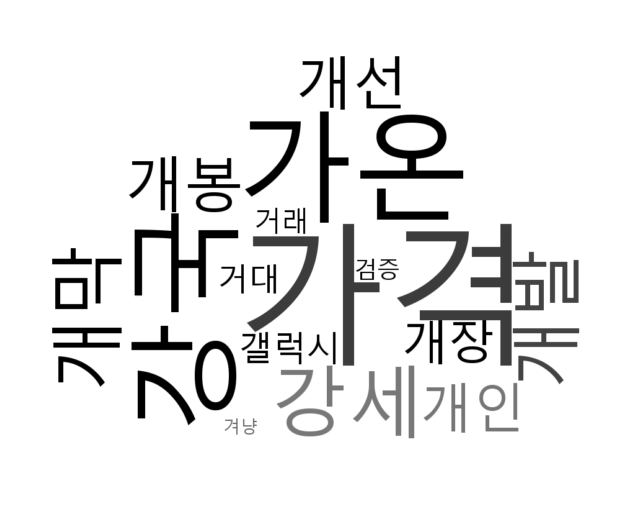

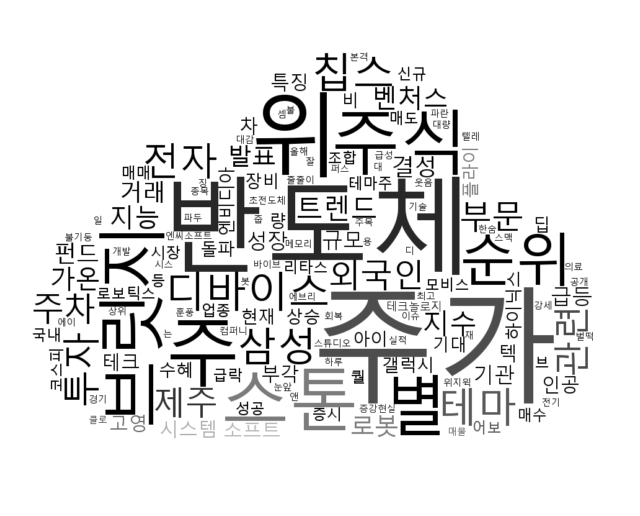

In [7]:
if __name__ == '__main__':
    stttext = news_title_value
    img_save_path = './img/'
    
    TA = TextAnalyzer()     # 텍스트 분석 클래스
    WA = WordAnalyzer(company)     # 단어 분석 클래스

    keywords      = WA.text2keywords(stttext)
    top3_keywords = list(WA.words2wordscount(keywords, 'individual'))[:3]         # 키워드 상위 3개
    countwords      = WA.text2countwords(stttext)                 
    top3_countwords = list(WA.words2wordscount(countwords, 'countwords'))[:3]     # 빈도수 높은 단어 상위 3개
    WA.visualize_wordcloud(stttext, 'keywords')       # 키워드 워드클라우드
    WA.visualize_wordcloud(stttext, 'countwords')     # 빈도수 높은 단어 워드클라우드
